In [1]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nsec.models.dae.convdae import SmallUResNet

In [3]:
import tensorflow_datasets as tfds
from jax.experimental import optix
import jax.numpy as jnp
from nsec.normalization import SNParamsTree as CustomSNParamsTree

In [4]:
import haiku as hk

In [5]:
# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

In [6]:
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.pad(train_images,((0,0),(2,2),(2,2),(0,0)))/255.

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.pad(test_images, ((0,0),(2,2),(2,2),(0,0)))/255.

In [7]:
def forward(x, s, is_training=False):
    denoiser = SmallUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [8]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)
import jax 

In [9]:
params, state = model.init(next(rng_seq), jnp.zeros((1, 32, 32, 1)), jnp.zeros((1, 1, 1, 1)), is_training=True)
opt_state = optimizer.init(params)

_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

In [10]:
batch_size=128
delta = 0.25

def get_batch():
    y = train_images[np.random.choice(len(train_images), batch_size)].astype('float32')
    u = np.random.randn(batch_size, 32,32,1)
    s = delta * np.random.randn(batch_size, 1, 1, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [11]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model.apply(params, state, rng_key, batch['x'], batch['s'], is_training=True)
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [12]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [13]:
losses = []

In [ ]:
for step in range(5000):
    batch = get_batch()
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.1458038
100 0.9420145
200 0.62282777
300 0.4859684
400 0.3409641
500 0.38938206
600 0.26161957
700 0.26766014
800 0.2651733
900 0.25789618
1000 0.23815782
1100 0.21112329
1200 0.2448647
1300 0.29124084
1400 0.21133499
1500 0.22098154
1600 0.23364559


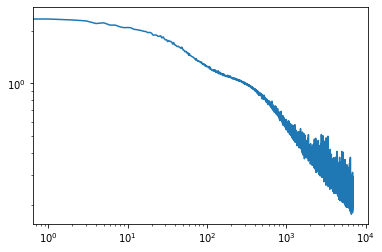

In [27]:
loglog(losses[10:])

In [16]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [24]:
batch = get_batch()
res, state = score(batch['x'],batch['s'], is_training=False)

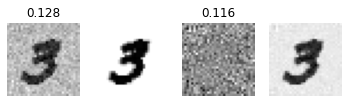

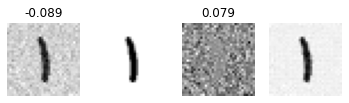

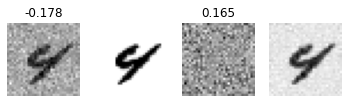

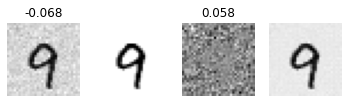

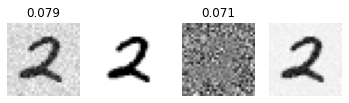

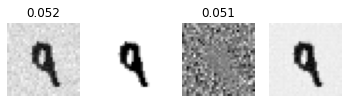

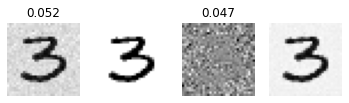

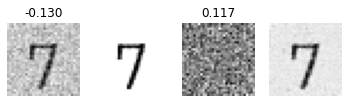

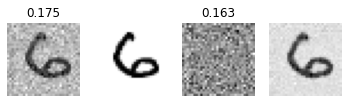

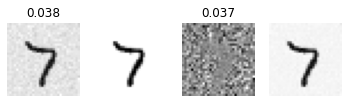

In [25]:
for i in range(10):
  ind = i
  figure()
  subplot(141)
  title("%0.3f"%batch['s'][ind,0,0,0])
  imshow(batch['x'][ind,...,0],cmap='gray_r')
  axis('off')
  subplot(142)
  imshow(batch['y'][ind,...,0],cmap='gray_r')
  axis('off')
  subplot(143)
  imshow(res[ind,...,0],cmap='gray_r')
  axis('off')
  title("%0.3f"%std(batch['s'][ind,:,:,0]**2 *res[ind,...,0]))
  subplot(144)
  imshow(batch['x'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='gray_r')
  axis('off')

In [38]:
# Trying to sample from the model
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

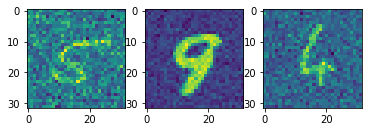

In [39]:
subplot(131)
imshow(batch['x'][0,...,0].reshape((32,32,)))
subplot(132)
imshow(batch['x'][1,...,0].reshape((32,32,)))
subplot(133)
imshow(batch['x'][2,...,0].reshape((32,32,)))

In [40]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

def score_fn(x):
    return score(x.reshape((1,32,32,1)),jnp.zeros((1,1,1,1)), is_training=False)[0].reshape((32*32,))

In [41]:
num_results = int(1e4)
num_burnin_steps = int(1e2)

In [42]:
@jax.jit
def get_samples():
    # First running SHMC
    kernel_shmc = ScoreHamiltonianMonteCarlo(
            target_score_fn=score_fn,
            num_leapfrog_steps=3,
            num_delta_logp_steps=4,
            step_size=0.01)
 
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state= batch['x'][0,...,0].reshape((32*32,)),#0.5*randn(32,32).reshape((32*32,)).astype('float32'),#
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
          seed=jax.random.PRNGKey(1))
    return samples_shmc, is_accepted_shmc 
 
samples_shmc, is_accepted_shmc = get_samples()

In [43]:
len(where(is_accepted_shmc)[0])

9266

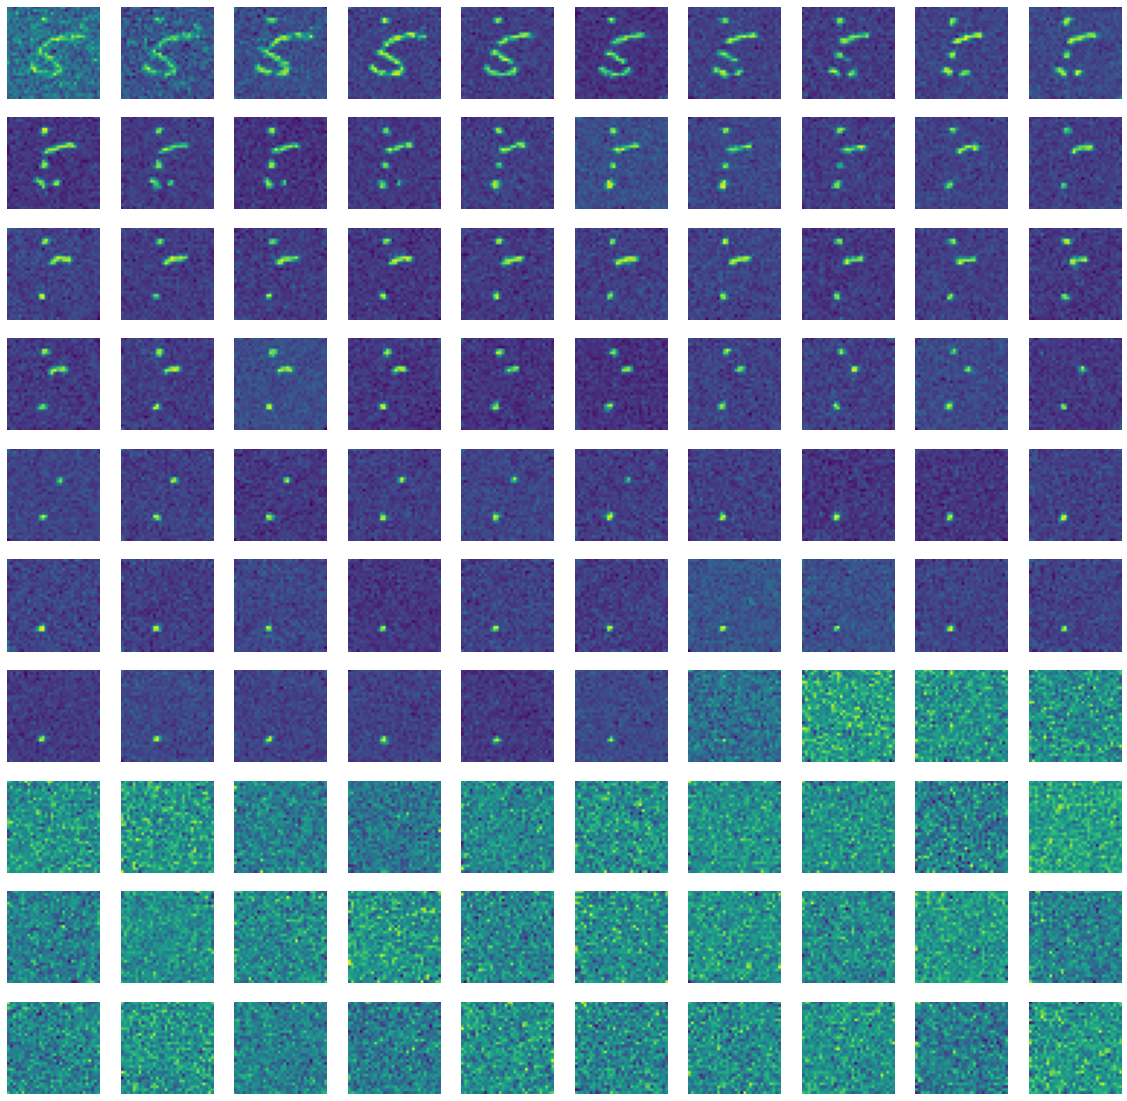

In [44]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

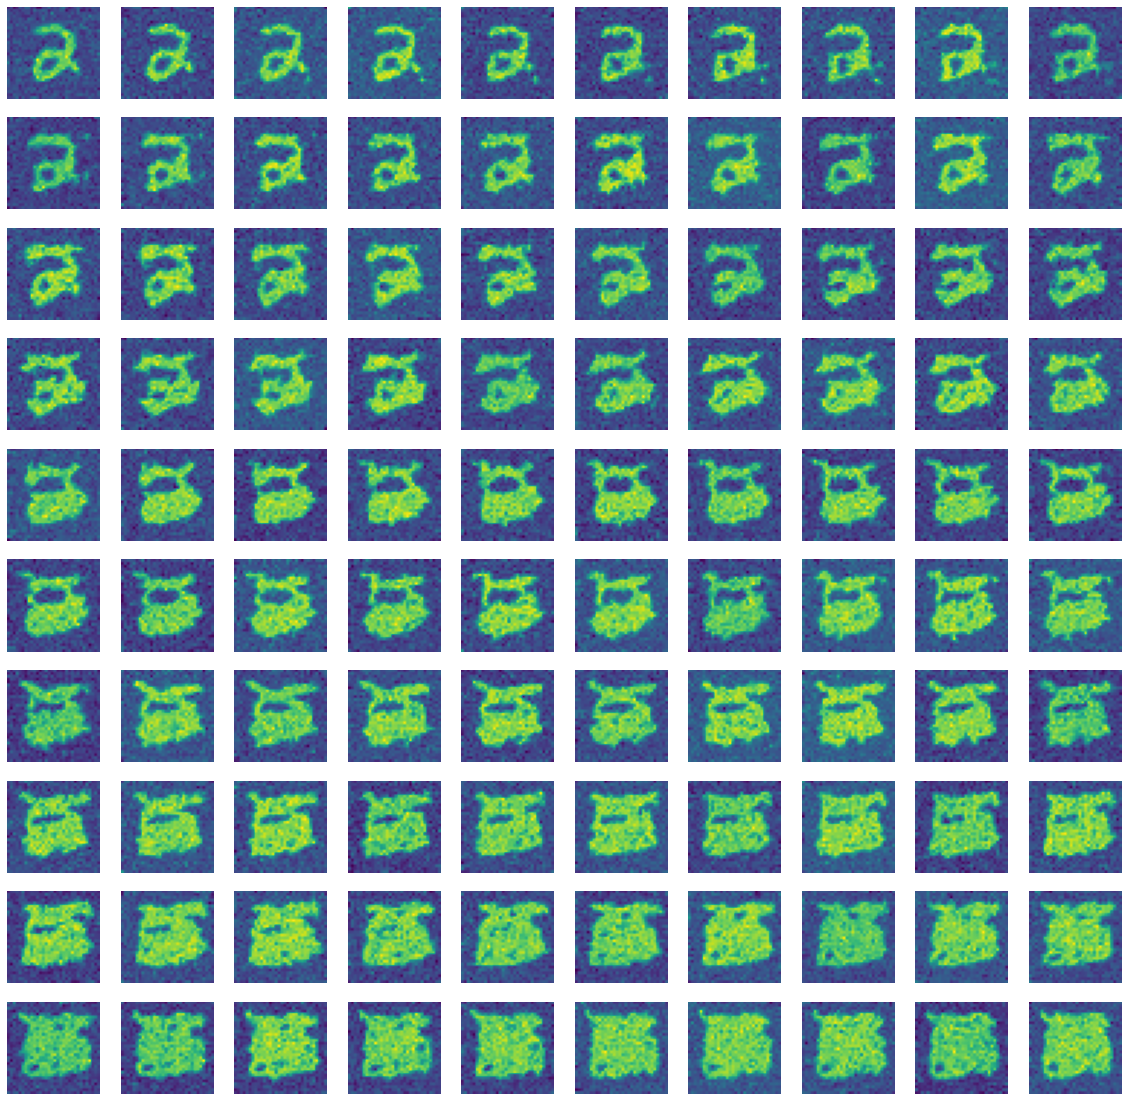

In [109]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

In [85]:
len(where(is_accepted_shmc)[0])

98298

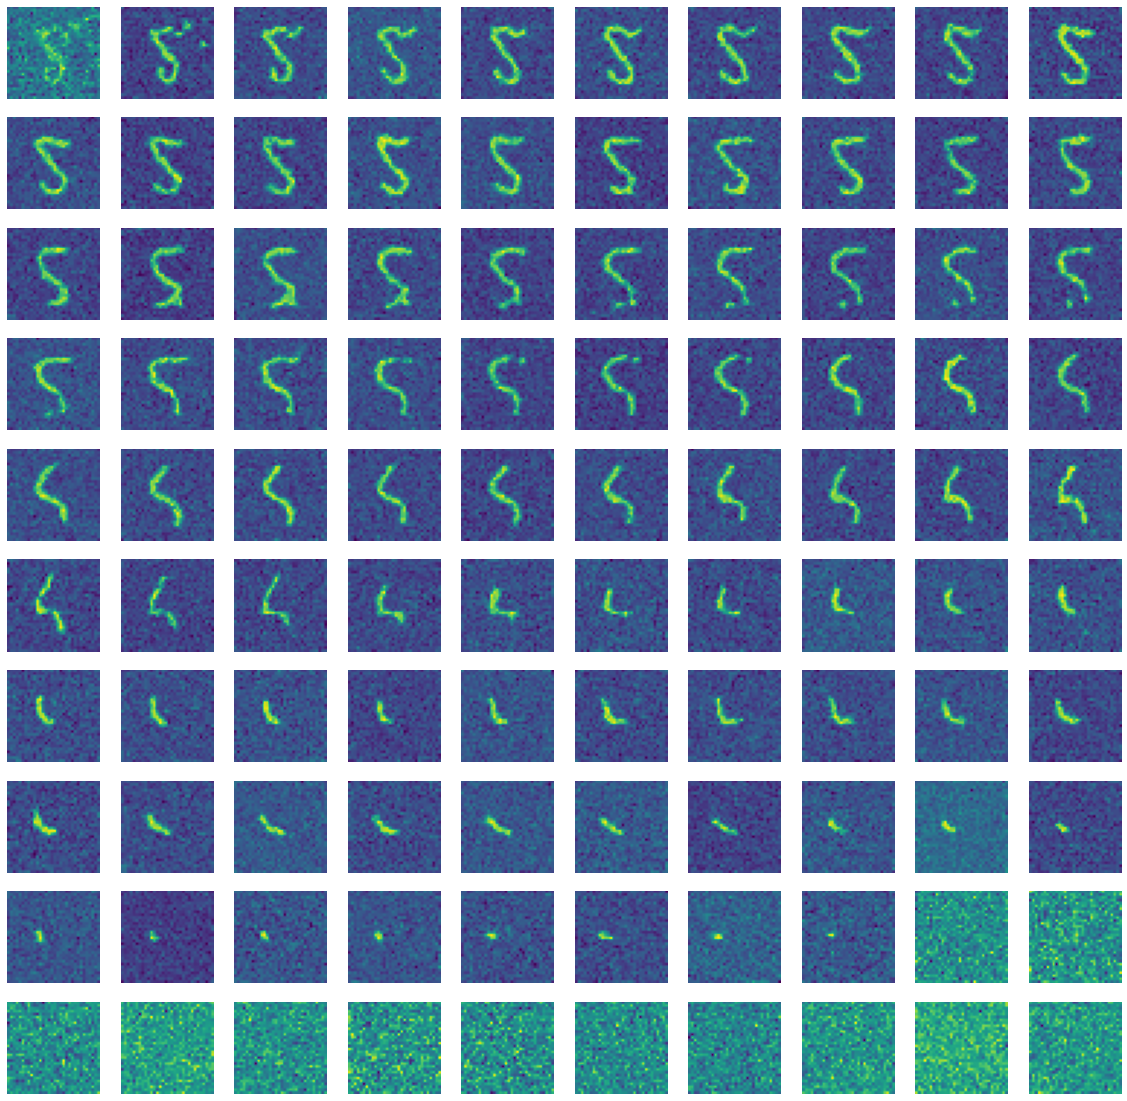

In [93]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*250].reshape((32,32)))
    axis('off')

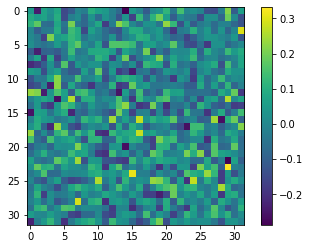

In [95]:
imshow(samples_shmc[-1].reshape((32,32))); colorbar()

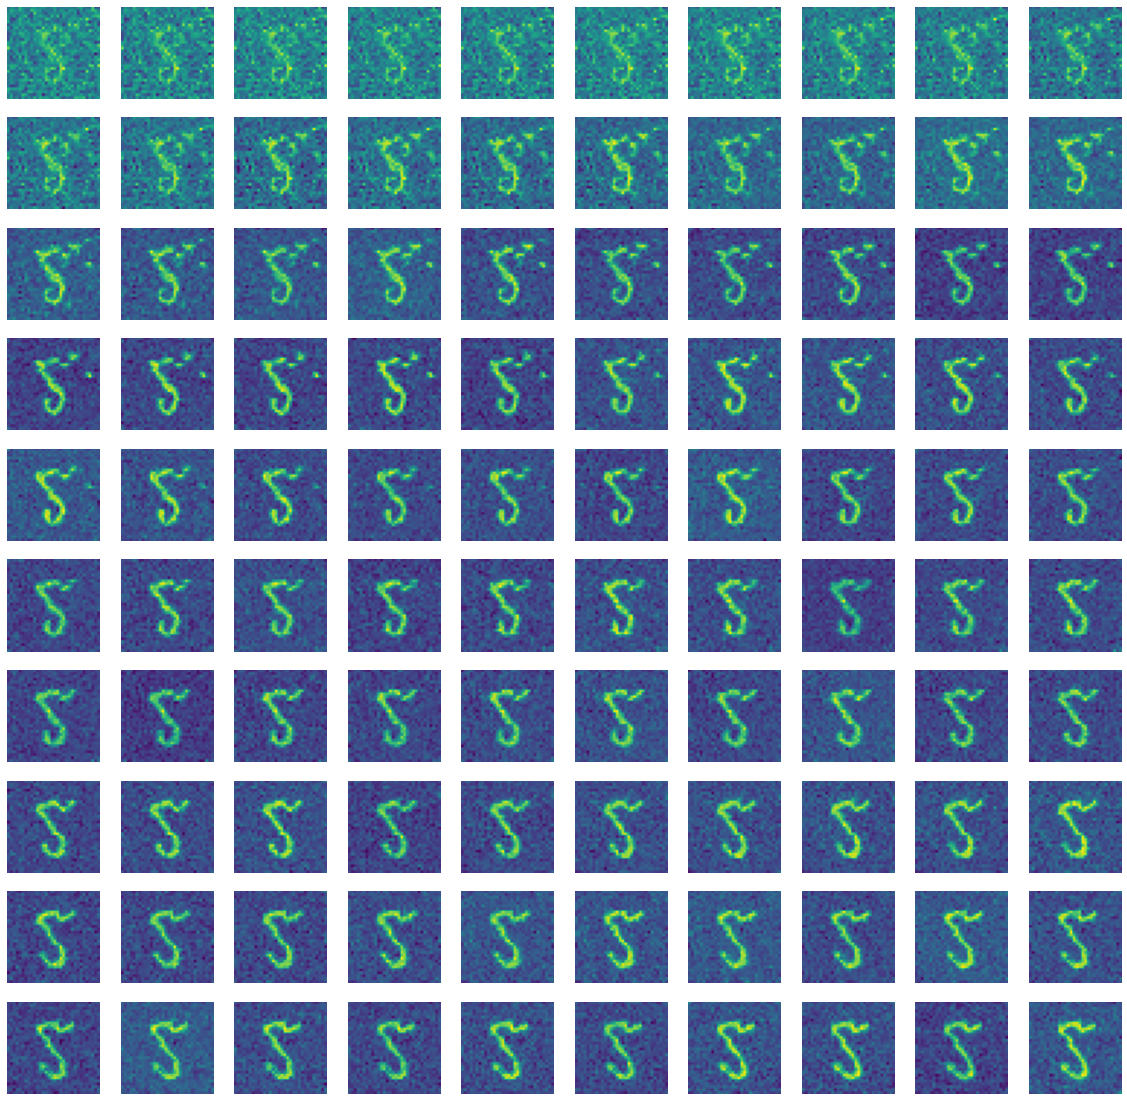

In [82]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*10].reshape((32,32)))
    axis('off')